11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Starting GAN training...
Epoch 1/25 - Gen Loss: 0.7349, Disc Loss: 1.1065
Epoch 2/25 - Gen Loss: 0.8547, Disc Loss: 1.2195
Epoch 3/25 - Gen Loss: 0.8845, Disc Loss: 1.1991
Epoch 4/25 - Gen Loss: 0.9484, Disc Loss: 1.1802
Epoch 5/25 - Gen Loss: 0.8622, Disc Loss: 1.3220


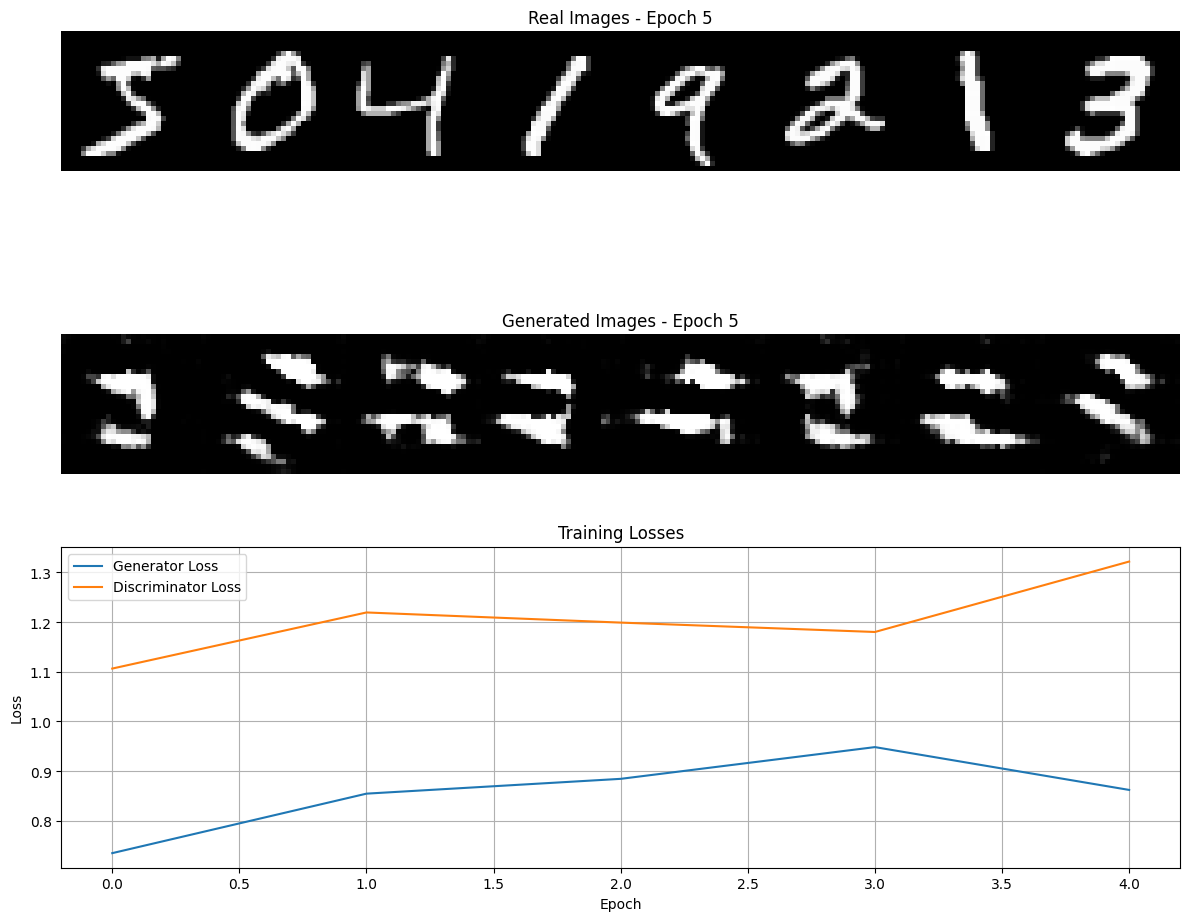

Epoch 6/25 - Gen Loss: 0.8341, Disc Loss: 1.2839
Epoch 7/25 - Gen Loss: 0.8491, Disc Loss: 1.2457
Epoch 8/25 - Gen Loss: 0.8421, Disc Loss: 1.2724
Epoch 9/25 - Gen Loss: 0.9585, Disc Loss: 1.1936
Epoch 10/25 - Gen Loss: 0.8961, Disc Loss: 1.2378


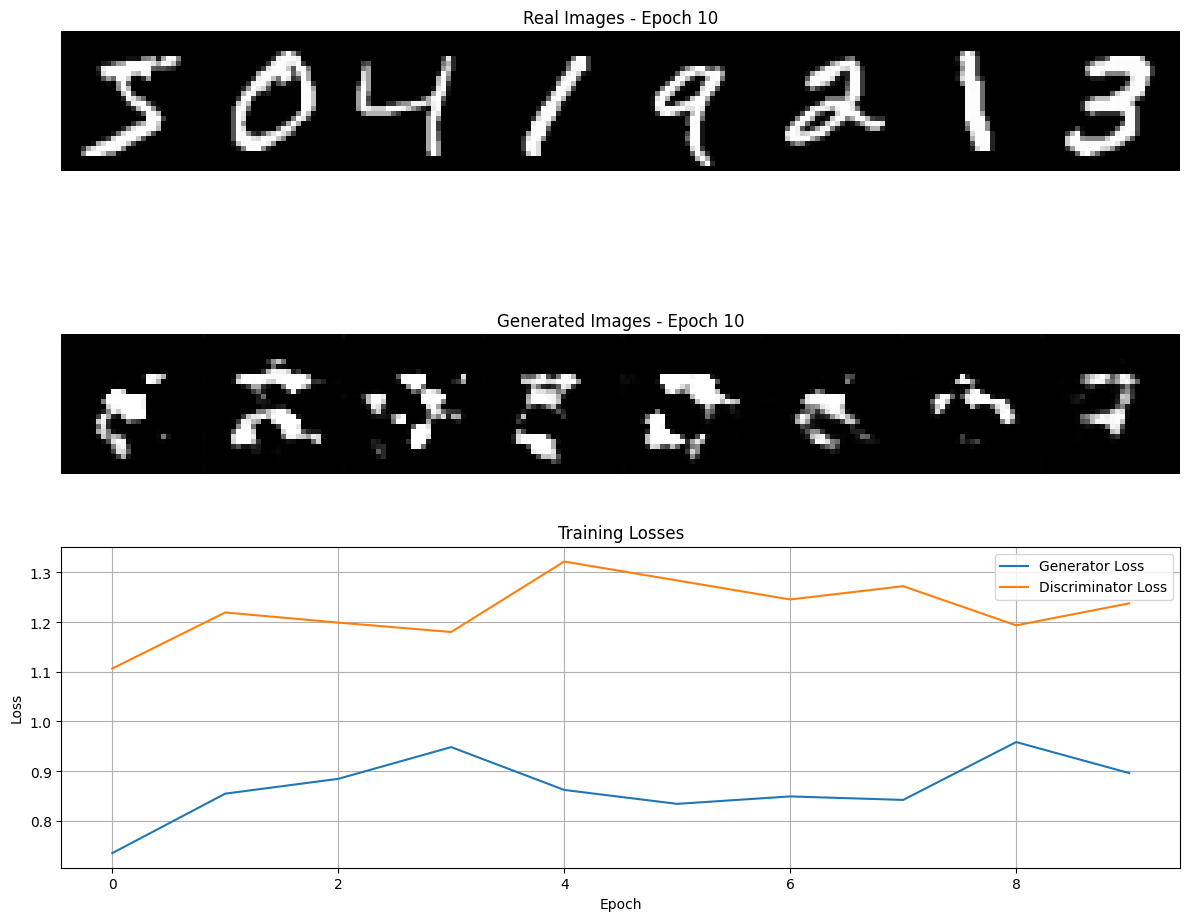

Epoch 11/25 - Gen Loss: 0.9854, Disc Loss: 1.1720
Epoch 12/25 - Gen Loss: 0.9513, Disc Loss: 1.2425
Epoch 13/25 - Gen Loss: 0.9462, Disc Loss: 1.1984
Epoch 14/25 - Gen Loss: 0.9682, Disc Loss: 1.1550
Epoch 15/25 - Gen Loss: 1.0439, Disc Loss: 1.1664


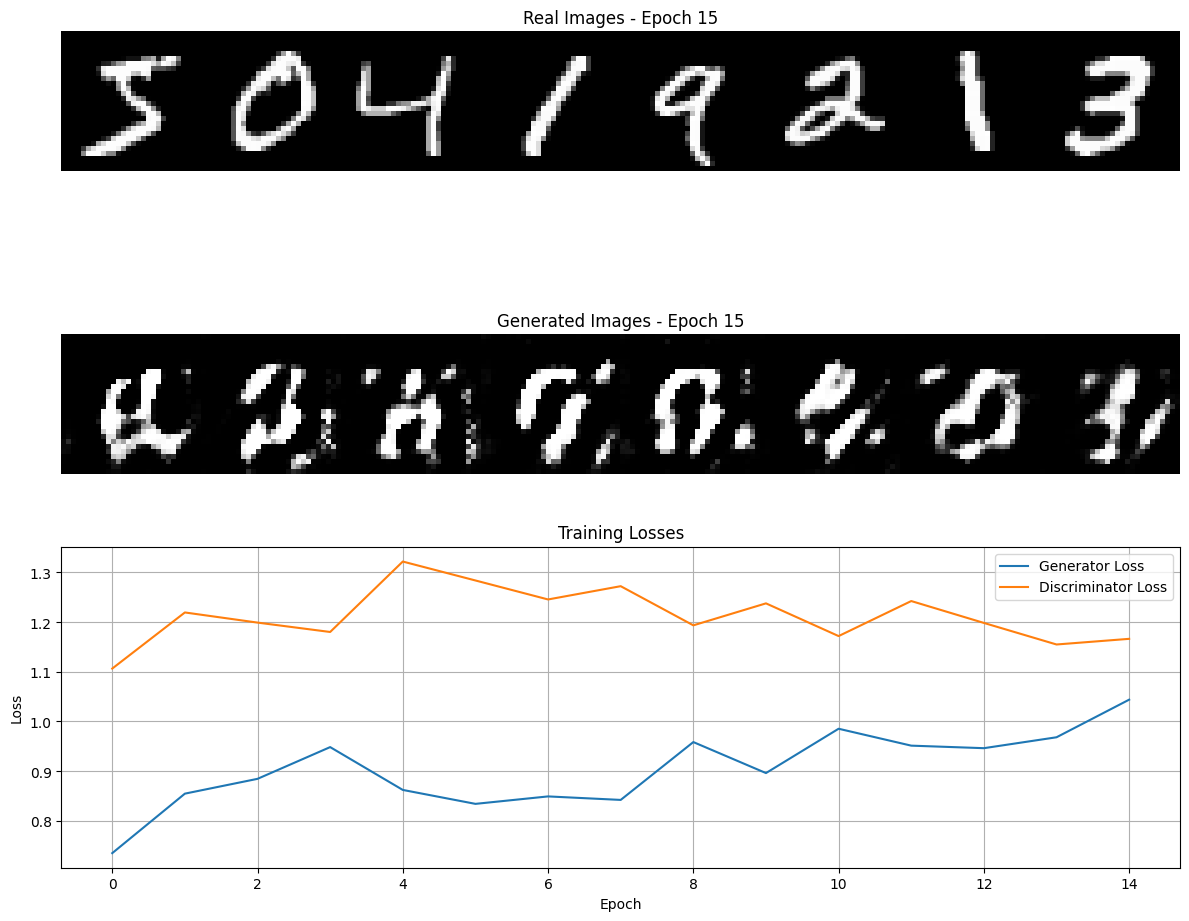

Epoch 16/25 - Gen Loss: 1.0611, Disc Loss: 1.0818
Epoch 17/25 - Gen Loss: 1.0678, Disc Loss: 1.1484
Epoch 18/25 - Gen Loss: 1.1961, Disc Loss: 1.0226
Epoch 19/25 - Gen Loss: 1.1335, Disc Loss: 1.0896
Epoch 20/25 - Gen Loss: 1.2266, Disc Loss: 1.0019


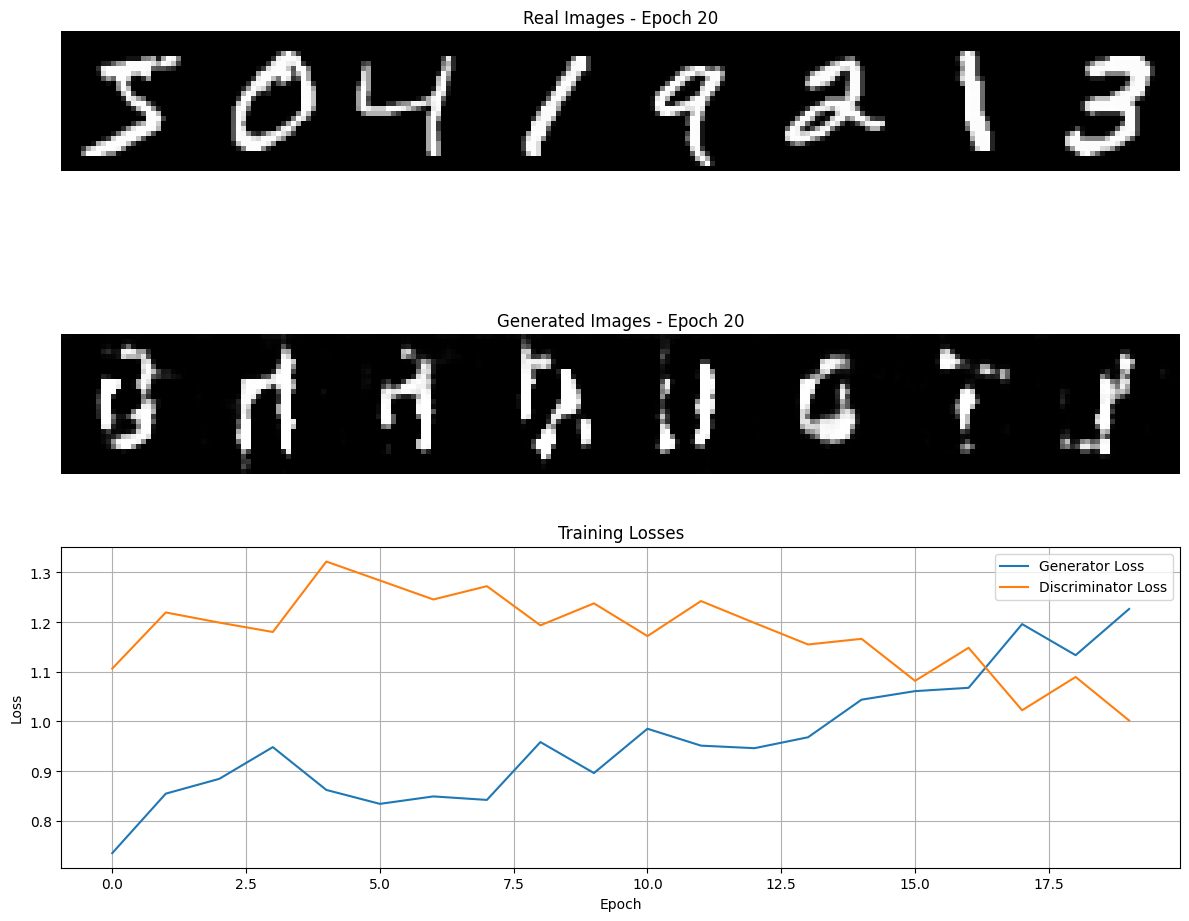

Epoch 21/25 - Gen Loss: 1.3076, Disc Loss: 1.0250
Epoch 22/25 - Gen Loss: 1.3259, Disc Loss: 0.9826
Epoch 23/25 - Gen Loss: 1.3318, Disc Loss: 1.0056
Epoch 24/25 - Gen Loss: 1.2064, Disc Loss: 1.0561
Epoch 25/25 - Gen Loss: 1.2041, Disc Loss: 1.0620


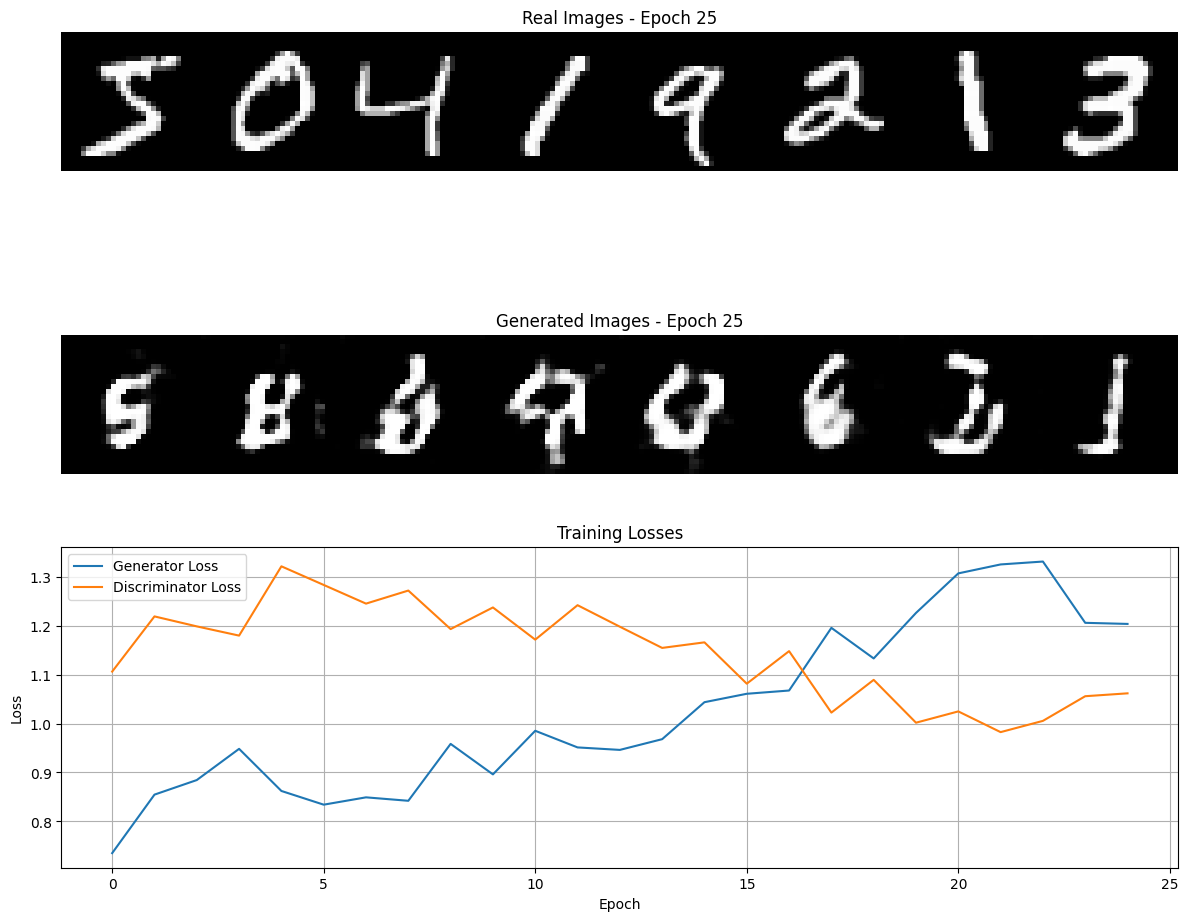

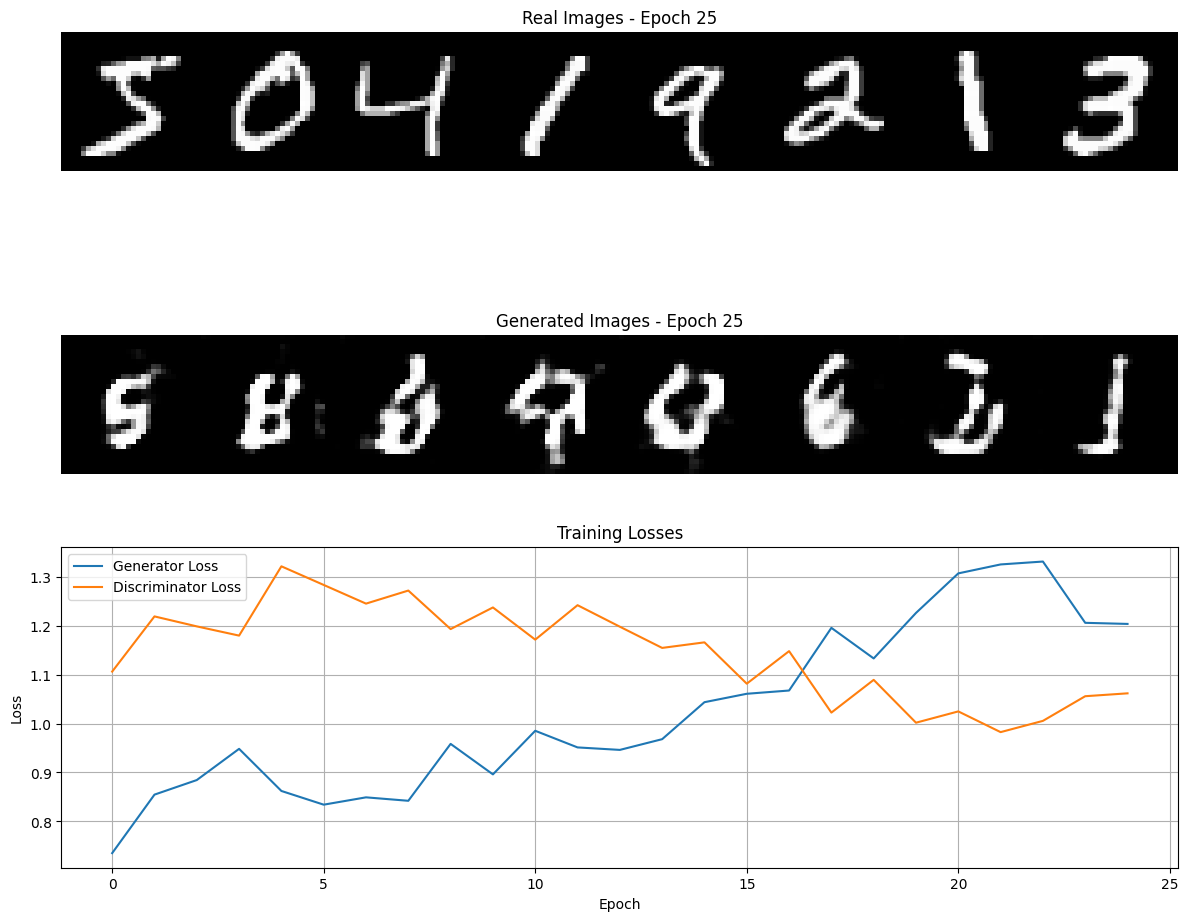

In [ ]:


import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

# Load and preprocess MNIST dataset
(train_images, _), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize to [-1, 1]

# Parameters
BUFFER_SIZE = 60000
BATCH_SIZE = 256
EPOCHS = 25
noise_dim = 100
num_examples_to_generate = 16

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Generator model
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(noise_dim,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    return model

# Discriminator model
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    return model

# Loss functions
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# Optimizers
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# Initialize models
generator = make_generator_model()
discriminator = make_discriminator_model()

# Generate and save images for visualization
seed = tf.random.normal([num_examples_to_generate, noise_dim])

# Lists to store losses
gen_losses = []
disc_losses = []

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

def train(dataset, epochs):
    for epoch in range(epochs):
        epoch_gen_loss = []
        epoch_disc_loss = []

        for image_batch in dataset:
            g_loss, d_loss = train_step(image_batch)
            epoch_gen_loss.append(g_loss)
            epoch_disc_loss.append(d_loss)

        # Calculate average loss for the epoch
        avg_gen_loss = np.mean(epoch_gen_loss)
        avg_disc_loss = np.mean(epoch_disc_loss)
        gen_losses.append(avg_gen_loss)
        disc_losses.append(avg_disc_loss)

        print(f'Epoch {epoch + 1}/{epochs} - Gen Loss: {avg_gen_loss:.4f}, Disc Loss: {avg_disc_loss:.4f}')

        # Generate images every 5 epochs
        if (epoch + 1) % 5 == 0 or epoch == epochs - 1:
            generate_and_plot_images(generator, epoch + 1, seed)

def generate_and_plot_images(model, epoch, test_input):
    # Generate images
    predictions = model(test_input, training=False)

    # Create figure with subplots
    fig = plt.figure(figsize=(12, 10))

    # Plot real images
    plt.subplot(3, 1, 1)
    real_images = train_images[:8]
    real_images = real_images.reshape(8, 28, 28)
    combined_real = np.hstack([real_images[i] for i in range(8)])
    plt.imshow(combined_real, cmap='gray')
    plt.title(f"Real Images - Epoch {epoch}")
    plt.axis('off')

    # Plot fake/generated images
    plt.subplot(3, 1, 2)
    generated_images = predictions.numpy()
    generated_images = generated_images.reshape(num_examples_to_generate, 28, 28)
    combined_fake = np.hstack([generated_images[i] for i in range(8)])
    plt.imshow(combined_fake, cmap='gray')
    plt.title(f"Generated Images - Epoch {epoch}")
    plt.axis('off')

    # Plot losses
    plt.subplot(3, 1, 3)
    plt.plot(gen_losses, label='Generator Loss')
    plt.plot(disc_losses, label='Discriminator Loss')
    plt.title('Training Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Start training
print("Starting GAN training...")
train(train_dataset, EPOCHS)

# Generate final images and losses
generate_and_plot_images(generator, EPOCHS, seed)

** GANs for generating synthetic datasets**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Generator
class Generator(nn.Module):
    def __init__(self, noise_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim),
            nn.Tanh()  # Output range [-1, 1]
        )

    def forward(self, x):
        return self.model(x)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()  # Probability output
        )

    def forward(self, x):
        return self.model(x)

# Hyperparameters
noise_dim = 100
data_dim = 784  # e.g., flattened 28x28 images
lr = 0.0002
epochs = 200
batch_size = 64

# Initialize models and optimizers
G = Generator(noise_dim, data_dim)
D = Discriminator(data_dim)
G_optimizer = optim.Adam(G.parameters(), lr=lr)
D_optimizer = optim.Adam(D.parameters(), lr=lr)

# Loss function
criterion = nn.BCELoss()

# Training loop (simplified)
for epoch in range(epochs):
    # Assume real_data is a batch from the dataset
    real_data = torch.randn(batch_size, data_dim)  # Placeholder
    real_labels = torch.ones(batch_size, 1)
    fake_labels = torch.zeros(batch_size, 1)

    # Train Discriminator
    D_optimizer.zero_grad()
    real_output = D(real_data)
    d_loss_real = criterion(real_output, real_labels)

    noise = torch.randn(batch_size, noise_dim)
    fake_data = G(noise)
    fake_output = D(fake_data.detach())
    d_loss_fake = criterion(fake_output, fake_labels)

    d_loss = d_loss_real + d_loss_fake
    d_loss.backward()
    D_optimizer.step()

    # Train Generator
    G_optimizer.zero_grad()
    fake_output = D(fake_data)
    g_loss = criterion(fake_output, real_labels)  # Fool the Discriminator
    g_loss.backward()
    G_optimizer.step()

    print(f"Epoch {epoch}, D Loss: {d_loss.item()}, G Loss: {g_loss.item()}")

# Generate synthetic data
noise = torch.randn(10, noise_dim)
synthetic_data = G(noise)

Epoch 0, D Loss: 1.3849598169326782, G Loss: 0.6848213076591492
Epoch 1, D Loss: 1.3269908428192139, G Loss: 0.6908121109008789
Epoch 2, D Loss: 1.3303923606872559, G Loss: 0.6952741742134094
Epoch 3, D Loss: 1.3170936107635498, G Loss: 0.7015909552574158
Epoch 4, D Loss: 1.3430728912353516, G Loss: 0.7062100172042847
Epoch 5, D Loss: 1.3042454719543457, G Loss: 0.7106066942214966
Epoch 6, D Loss: 1.3027377128601074, G Loss: 0.7131630182266235
Epoch 7, D Loss: 1.3012773990631104, G Loss: 0.7199525833129883
Epoch 8, D Loss: 1.2798326015472412, G Loss: 0.7231944799423218
Epoch 9, D Loss: 1.253566026687622, G Loss: 0.7298039197921753
Epoch 10, D Loss: 1.2780611515045166, G Loss: 0.7312931418418884
Epoch 11, D Loss: 1.2739906311035156, G Loss: 0.7366844415664673
Epoch 12, D Loss: 1.2737189531326294, G Loss: 0.7363312244415283
Epoch 13, D Loss: 1.2524734735488892, G Loss: 0.7412818074226379
Epoch 14, D Loss: 1.2437070608139038, G Loss: 0.7450071573257446
Epoch 15, D Loss: 1.2442865371704102